In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import datetime as dt
pd.options.display.max_columns = None
from datetime import timedelta
from nltk import word_tokenize
import zipfile
os.getcwd()
import seaborn as sns
from sklearn.metrics import mean_absolute_error
import nltk
from wordcloud import WordCloud, STOPWORDS
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words_sp = set(stopwords.words('spanish'))
stop_words_en = set(stopwords.words('english'))
#Concatenar las stopwords aplicándose a una cuenta que genera contenido en inglés y español
stop_words = stop_words_sp | stop_words_en 
from nltk import ngrams
import re

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Usser\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Posterior al contacto de una persona con la marca (ya sea que adquiera una motocicleta o asista a un taller de servicio) enviamos una encuesta para medir como fue la experiencia y qué tan satisfecho esta.

Para este fin se utiliza el NPS (Net Promoter Score) donde se consulta si el cliente nos recomendaría, de tal forma que suponemos que los clientes que respondan con calificaciones altas promocionaran nuestros productos entre otros clientes potenciales cercanos a ellos, mientras que aquellos con calificaciones bajas no están contentos y es poco probable que nos ayuden a aumentar la base de datos de clientes.

Según las calificaciones otorgadas, los clientes se pueden dividir en:
1. Detractores: Los usuarios que nos califican de 0 a 6.
2. Pasivos: Los usuarios que nos califican con 7 u 8.
3. Promotores: Los usuarios que nos califican con 9 o 10.

En esta encuesta además hay un campo en el que los clientes pueden escribirnos cómo se sienten con la marca y la experiencia recibida.


Problema de negocio: 
Durante años ha venido ejecutándose el envío de la encuesta y la recolección de los datos asociados con la experiencia del cliente (en qué tienda se atendió, quién lo atendió, qué producto nos compró o llevó para reparación, si le toco volver o no por algún problema con el servicio técnico, etc.), además de los múltiples comentarios que nos hace el cliente en cada uno de sus contactos con la marca.

Nos interesa saber qué tan positiva es la percepción de la marca (no sólo medido en términos cuantitativos con el NPS, sino con los sentimientos asociados a los comentarios de los clientes) y si existe correlación con otros factores.

Por ejemplo: ¿que la experiencia sea o no positiva depende del tipo de moto que hayan comprado? ¿De quién los atienda? ¿De la tienda donde sea atendido? ¿Necesariamente un NPS alto implica un comentario positivo? ¿El NPS ha mejorado en el tiempo? ¿Hay algún factor o tema que haya mejorado o empeorado en el tiempo?


A partir del dataset “NPS.csv” realice un análisis de sentimientos y concluya acerca de sus hallazgos. 
A continuación, el significado de cada variable:

* Tienda: ID que nos indica la tienda a la que asistió el cliente.
* NoPersonal: ID del vendedor o técnico que atendió al cliente.
* ModeloMoto: ID de la motocicleta vendida o atendida.
* Nombre_Encuesta: indica si la encuesta se aplicó después de adquirir una moto o asistir a un taller de servicio técnico.
* Fecha_Rpta_Encuesta: fecha en que el cliente responde la encuesta
* Valor_NPS: puntaje otorgado por el cliente en la encuesta (ver contexto)
* Tasa_Retorno: variable binaria donde 1 indica que el cliente tuvo que regresar al taller y 0 que no (sólo aplica para encuestas de servicio técnico)
* Fecha_Venta_Servicio: fecha en la que el cliente compró la moto o asistió a servicio
* Comentario: el comentario que nos dejó el cliente en la encuesta respecto a su experiencia
* Motivo_Retorno: detalle que nos da el cliente acerca de por qué tuvo que regresar a servicio técnico.


In [3]:
nps=pd.read_csv(r"D:\Desktop\ITS_\YAMAHA\NPS.csv",sep=';',encoding='ISO-8859-1',dtype='str')

In [4]:
nps['Comentario']=nps['Comentario'].str.lower().str.translate(str.maketrans('áéíóú', 'aeiou'))

In [5]:
########################### Parse dates #####################
nps['Fecha_Rpta_Encuesta']=pd.to_datetime(nps['Fecha_Rpta_Encuesta'],format='%d/%m/%Y',errors = "coerce")
nps['Fecha_Venta_Servicio']=pd.to_datetime(nps['Fecha_Venta_Servicio'],format='%d/%m/%Y',errors = "coerce")


########################### Cleaning #######################
nps['Comentario']=nps['Comentario'].str.lower()
nps['Valor_NPS']=pd.to_numeric(nps['Valor_NPS'],errors='coerce')
nps['ModeloMoto'][nps['ModeloMoto'].isna()] = nps['ModeloMoto'].mode()[0]

########################## creación de variables ##########
nps["Dias_para_encuesta"] = (nps['Fecha_Rpta_Encuesta']-nps['Fecha_Venta_Servicio']).dt.days


C:\Users\Usser\anaconda3\envs\myenv\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


In [6]:
col         = 'Valor_NPS'
condi = [(nps[col].between(0, 6, inclusive = True)),
        (nps[col].between(6, 8, inclusive = True)),
        (nps[col].between(8, 10, inclusive = True))
        ]
nps_     = [ "Detractor", 'Pasivo','Promotor'] 
nps["NPS_CUALI"] = np.select(condi, nps_, default=np.nan)

In [7]:
print(nps["NPS_CUALI"].value_counts(True))
print(nps['Nombre_Encuesta'].value_counts(True))

Promotor     0.774961
Pasivo       0.151312
Detractor    0.073726
Name: NPS_CUALI, dtype: float64
Experiencia Servicio MC    0.523306
Experiencia Venta MC       0.476694
Name: Nombre_Encuesta, dtype: float64


In [8]:
### Validación de la calidad en la data debe ser cero para que aplique la encuesta y se cumpla con criterios de calidad, de lo contrario se puede tratar o eliminar dado la cantidad de casos
(nps['Fecha_Venta_Servicio']>nps['Fecha_Rpta_Encuesta']).sum()

0

In [9]:
nps[['Fecha_Venta_Servicio','Fecha_Rpta_Encuesta']]

,Fecha_Venta_Servicio,Fecha_Rpta_Encuesta
0,2020-03-17,2020-05-30
1,2020-05-11,2020-05-27
2,2020-05-12,2020-05-27
3,2020-05-11,2020-05-25
4,2020-05-14,2020-05-22
...,...,...
40157,2021-07-12,2021-08-03
40158,2021-07-03,2021-08-03
40159,2021-07-08,2021-08-03
40160,2021-07-14,2021-08-01


### Correlación con otros factores
* Método, tablas de contingencia y evaluación de correlaciones chi-cuadrado con otras variables
* 

In [11]:
### tomo las personas con el servicio de venta vs el modelo, el obetivo es observar las distribuciones
venta=nps[nps['Nombre_Encuesta']=='Experiencia Venta MC']
pd.crosstab(venta['NPS_CUALI'],venta['ModeloMoto'])

ModeloMoto,0,1,10,12,13,16,18,19,2,20,21,22,23,24,25,26,27,29,30,31,32,34,35,38,41,42,45,46,48,49,51,53,54,56,58,60,61,63,66,67,69,7,70,71,72,73,74,75,76,77,78,79,8
NPS_CUALI,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Detractor,0,53,3,6,37,78,87,0,44,0,20,9,3,2,3,0,0,4,24,0,13,0,1,45,0,1,3,2,0,1,0,4,0,1,12,105,46,0,5,24,0,179,21,0,0,0,0,0,0,34,0,0,10
Pasivo,0,145,13,22,84,282,303,0,148,0,58,39,3,6,8,1,1,13,43,1,37,0,0,100,0,2,5,3,1,3,0,9,0,3,29,237,185,1,18,82,0,444,46,0,0,0,1,0,0,105,0,1,24
Promotor,4,1317,41,95,487,1281,2333,1,1376,1,375,128,36,24,53,0,5,105,242,2,124,1,3,759,4,15,9,11,0,5,1,60,7,14,235,1522,1010,8,80,574,1,2490,401,2,1,1,2,1,2,339,1,3,167


In [12]:
venta=nps[nps['Nombre_Encuesta']=='Experiencia Venta MC']
pd.crosstab(venta['NPS_CUALI'],venta['Tienda'])

Tienda,0,1,10,100,101,102,103,104,105,106,107,108,109,11,110,111,112,113,114,115,116,117,118,119,12,120,121,122,123,124,125,126,127,129,130,131,132,133,134,135,136,137,138,139,14,140,141,142,143,144,145,146,147,149,15,150,151,152,153,154,155,159,16,160,161,162,165,166,170,171,172,173,175,176,177,178,179,18,180,181,182,183,184,185,186,187,189,19,190,191,192,193,194,196,2,20,200,201,202,203,204,205,206,207,208,21,211,213,214,215,216,217,219,22,220,221,222,223,224,226,227,229,23,230,233,234,235,236,238,239,24,240,241,242,243,244,246,247,248,249,25,250,251,252,253,255,256,257,258,259,26,260,263,264,265,266,267,268,269,27,270,271,272,273,274,276,277,278,28,280,281,284,285,288,291,292,293,294,295,296,297,298,299,3,30,300,301,302,303,304,305,307,308,309,31,310,311,312,313,314,315,316,318,319,32,320,321,323,326,33,330,331,332,334,335,336,337,339,34,340,341,342,343,344,345,346,347,348,35,351,352,353,354,355,357,358,36,361,363,364,365,366,367,368,369,37,370,371,372,374,376,377,378,38,380,382,383,384,385,386,387,388,389,39,390,391,392,393,394,395,396,397,398,399,4,40,400,402,403,404,406,407,408,409,41,410,411,412,414,415,416,417,418,419,42,420,421,422,424,428,429,43,430,431,432,433,434,44,45,46,47,48,49,5,50,51,52,53,54,55,56,57,58,59,6,60,61,62,63,64,65,66,67,68,69,7,70,71,72,73,75,77,78,79,8,80,81,82,83,84,85,86,87,88,89,9,90,91,92,93,94,95,96,97,98,99
NPS_CUALI,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Detractor,0,3,0,3,0,6,0,3,3,1,3,0,7,0,4,2,0,5,0,0,1,0,0,5,1,0,1,0,1,0,0,0,0,16,1,13,0,4,7,0,9,7,0,1,1,3,0,1,0,3,11,1,3,0,0,2,0,0,0,4,0,2,0,0,2,1,0,0,0,0,0,2,7,1,0,0,0,1,1,1,0,0,1,3,7,0,2,0,5,7,7,1,3,1,0,1,1,8,2,0,1,2,1,1,1,0,1,0,1,1,0,1,0,2,2,0,4,0,0,2,0,0,1,0,4,1,6,0,1,0,0,0,1,0,0,1,2,1,2,0,1,0,0,2,0,0,1,2,0,0,1,0,3,0,0,0,2,1,0,0,0,0,0,1,0,0,3,2,0,1,3,0,0,0,3,5,32,13,34,11,5,2,17,0,1,2,0,3,3,0,0,0,0,0,0,2,0,5,2,0,0,0,0,0,1,2,0,0,0,0,0,0,1,3,0,4,0,0,1,0,1,0,0,0,0,2,0,0,1,13,6,0,3,0,2,3,0,3,0,0,1,1,2,1,0,3,4,0,0,0,0,2,0,0,0,1,0,0,16,0,2,0,0,1,1,0,0,2,1,0,0,0,0,0,0,2,2,0,0,1,0,0,1,0,0,0,1,0,1,0,0,0,0,0,2,0,0,0,0,0,69,0,12,42,71,9,9,0,13,3,7,4,3,0,8,0,3,0,0,3,0,0,0,0,0,0,4,4,4,7,1,0,0,0,2,0,0,0,0,1,0,0,4,4,1,0,3,1,36,21,2,5,9,6,0,2,1,0,0,0,0,1,0,0,0,0
Pasivo,0,0,0,8,0,13,0,5,18,5,6,1,13,0,13,8,0,10,1,1,5,1,0,10,0,1,5,0,0,0,2,0,0,37,2,16,2,2,38,5,23,17,0,12,0,12,0,13,2,9,22,6,22,1,0,1,0,1,0,8,1,0,0,0,0,2,0,1,2,2,0,10,23,3,6,6,1,1,4,0,0,3,0,11,5,1,8,2,7,19,46,3,16,7,1,6,0,14,3,0,3,9,5,1,3,0,3,2,0,3,0,3,8,11,5,3,6,5,3,10,2,2,0,2,4,1,13,0,1,1,0,0,3,7,1,3,1,1,5,0,7,2,1,4,0,3,1,6,0,0,1,4,9,1,6,1,5,9,6,0,0,2,1,0,0,2,8,2,0,3,2,1,0,2,11,16,47,22,66,21,3,0,49,1,0,10,1,6,10,0,0,0,1,0,0,2,0,10,0,0,1,2,0,1,7,5,2,1,2,8,0,0,7,4,2,10,4,1,8,0,2,0,3,0,0,5,0,0,2,21,9,5,1,0,2,2,0,15,0,1,4,0,2,4,1,3,3,0,1,0,0,1,3,2,4,6,0,0,23,3,8,2,4,8,5,0,2,12,0,1,2,2,0,0,9,2,9,1,0,2,1,1,6,0,1,3,0,0,0,1,0,1,0,1,9,0,3,0,0,2,253,0,44,77,214,43,37,0,31,10,8,8,2,4,24,0,4,0,8,9,2,2,1,3,0,5,13,7,8,17,5,5,0,8,6,2,0,5,3,1,1,0,22,11,4,18,5,7,80,20,5,7,21,14,3,4,8,7,0,5,4,2,0,0,2,0
Promotor,1,5,3,46,4,36,2,27,94,41,37,9,101,1,109,43,16,64,4,13,26,1,2,69,9,0,8,1,1,1,2,1,1,175,12,102,12,33,113,16,127,46,1,78,8,89,1,115,16,103,155,36,95,4,2,14,1,0,4,32,1,8,9,2,6,3,2,20,24,28,12,90,123,15,19,19,27,10,27,11,5,9,17,153,4,2,38,8,44,94,124,11,81,42,23,25,9,71,22,1,16,61,89,8,83,14,33,24,5,12,2,31,17,48,52,10,34,40,16,74,29,23,10,28,19,1,20,1,9,13,11,2,28,67,0,33,13,9,32,4,61,4,1,14,2,11,5,47,1,3,5,16,74,19,57,16,30,59,39,10,1,15,3,12,7,5,45,10,1,12,10,6,2,17,82,134,229,85,259,77,32,1,123,7,5,29,14,11,113,4,3,7,6,8,3,6,1,39,9,1,2,22,1,14,40,27,9,10,24,37,18,3,46,34,9,66,16,1,34,1,38,2,12,4,14,28,3,4,12,109,53,25,22,24,20,27,2,147,2,8,32,8,10,21,38,17,21,8,1,9,9,43,13,15,8,20,1

In [13]:
########################################## ~ Análisis ventas ~ #############################################

In [14]:
R_daily=venta.groupby([pd.Grouper(key='Fecha_Venta_Servicio',freq='m')]).agg({'Valor_NPS':'mean'})

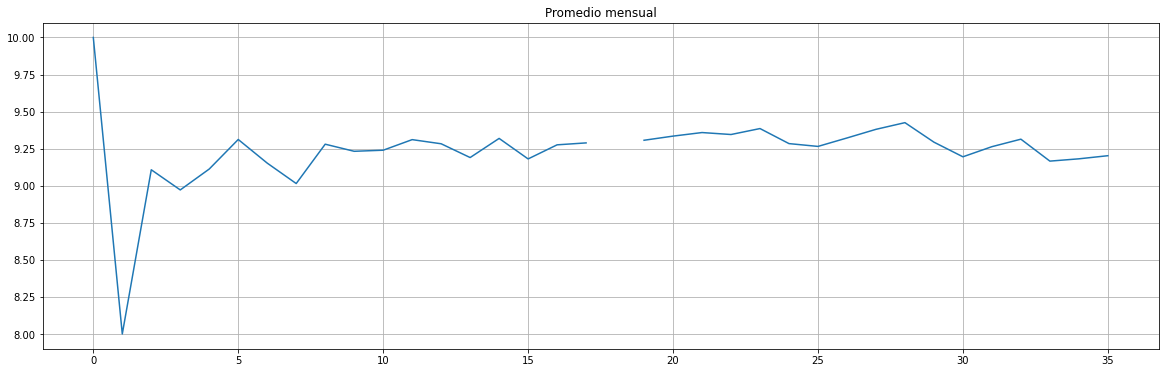

In [15]:
R_daily=R_daily.reset_index()
plt.figure(figsize=(20, 6))
plt.plot(R_daily.Valor_NPS)
plt.title('Promedio mensual')
plt.grid(True)
plt.show()
### Comportamiento muy estable que se puede profundizar un poco más

In [16]:
def plotMovingAverage(series, window, plot_intervals=False, scale=1.96, 
                      plot_anomalies=False):

    """
        series - dataframe with timeseries
        window - rolling window size 
        plot_intervals - show confidence intervals
        plot_anomalies - show anomalies 

    """
    rolling_mean = series.rolling(window=window).mean()

    plt.figure(figsize=(15,5))
    plt.title("Moving average\n window size = {}".format(window))
    plt.plot(rolling_mean, "black", label="Rolling mean trend")

    # Plot confidence intervals for smoothed values
    if plot_intervals:
        mae = mean_absolute_error(series[window:], rolling_mean[window:])
        deviation = np.std(series[window:] - rolling_mean[window:])
        lower_bond = rolling_mean - (mae + scale * deviation)
        upper_bond = rolling_mean + (mae + scale * deviation)
        plt.plot(upper_bond, "r--", label="Upper Bond / Lower Bond")
        plt.plot(lower_bond, "r--")
        
        # Having the intervals, find abnormal values
        if plot_anomalies:
            anomalies = pd.DataFrame(index=series.index, columns=series.columns)
            anomalies[series<lower_bond] = series[series<lower_bond]
            anomalies[series>upper_bond] = series[series>upper_bond]
            plt.plot(anomalies, "ro", markersize=10)
        
    plt.plot(series[window:], label="Actual values")
    plt.legend(loc="upper left")
    plt.grid(True)

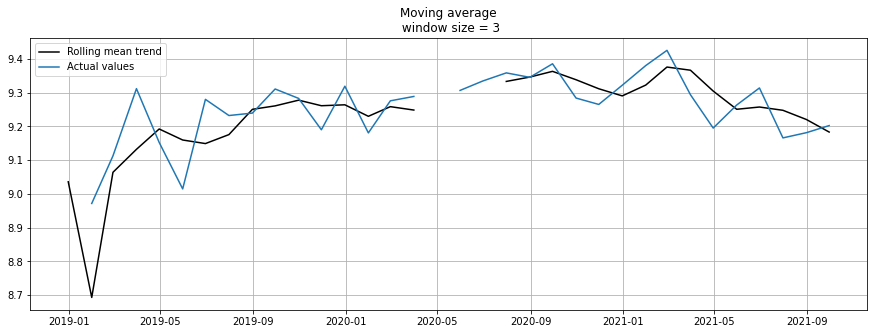

In [17]:
######## Messual ############
R_daily=venta.groupby([pd.Grouper(key='Fecha_Venta_Servicio',freq='m')]).agg({'Valor_NPS':'mean'}) ## semanal
plotMovingAverage(R_daily, 3)

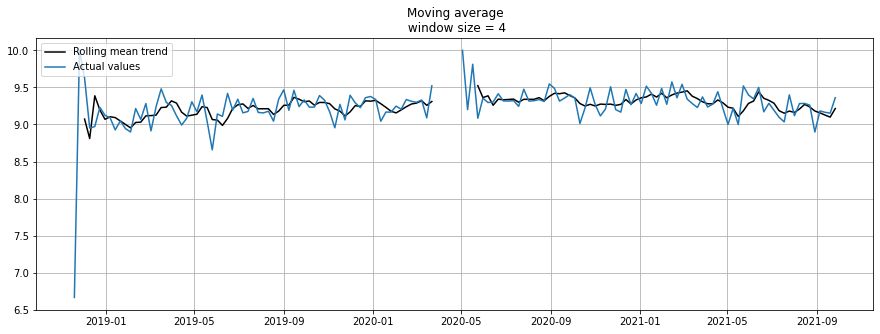

In [18]:
########### SEMANAL ##############
R_daily=venta.groupby([pd.Grouper(key='Fecha_Venta_Servicio',freq='w')]).agg({'Valor_NPS':'mean'}) ## semanal
plotMovingAverage(R_daily, 4)

In [19]:
R_daily.dropna(subset=['Valor_NPS'],inplace=True)

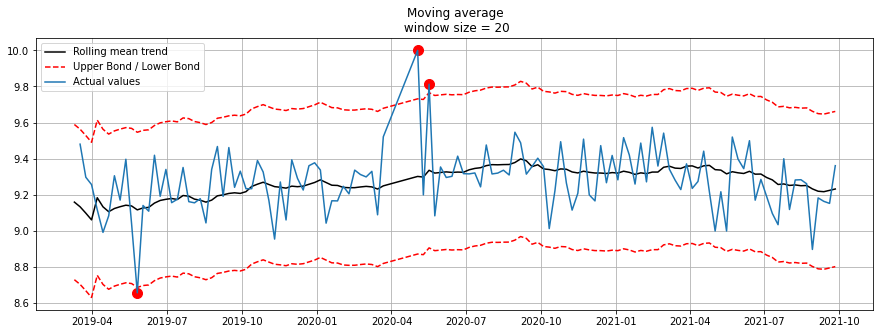

In [20]:
plotMovingAverage(R_daily, 20, plot_intervals=True, plot_anomalies=True)
# ¿Qué pasó en el periodo durante la pandemia?
# ¿Qué sucedió a mediados del 2019 que el NPS medio cayó? 

¿El NPS ha mejorado en el tiempo? ¿Hay algún factor o tema que haya mejorado o empeorado en el tiempo?


In [21]:
### Profundizar exactamente donde se encuentra focalizado el pico por tienda (estamos )

In [22]:
########################################## ~ Servicio mecanico ~ #############################################

In [23]:
serv_mecanico=nps[nps['Nombre_Encuesta']=='Experiencia Servicio MC']

In [24]:
R_week=serv_mecanico.groupby([pd.Grouper(key='Fecha_Venta_Servicio',freq='w')]).agg({'Valor_NPS':'mean'})

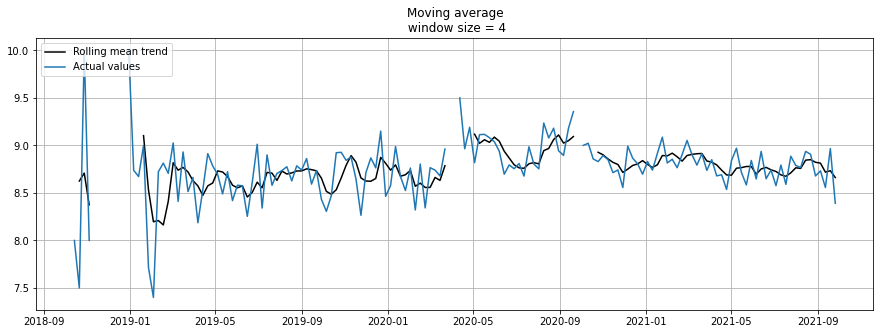

In [25]:
plotMovingAverage(R_week, 4)

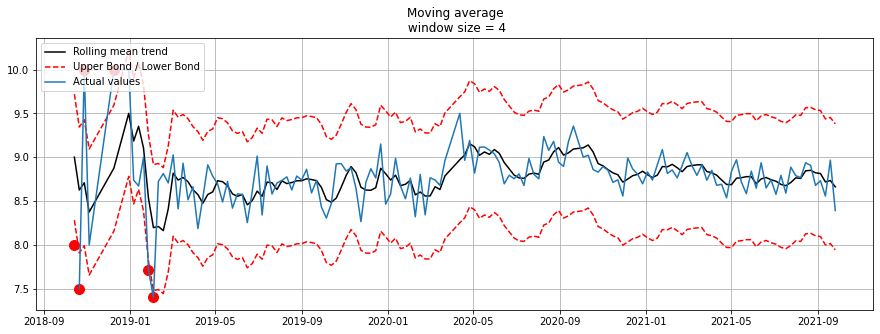

In [26]:
R_week.dropna(subset=['Valor_NPS'],inplace=True)
plotMovingAverage(R_week, 4, plot_intervals=True, plot_anomalies=True)

In [27]:
nps['NoPersonal'].nunique()

1892

### Análisis de texto ###
* ¿los promotores/pasivos/detractores que destacan por grupo?
* Analisis de texto por medio de expereincia en venta MC
* Motivo de retorno

In [28]:
nps.columns

Index(['Tienda', 'NoPersonal', 'ModeloMoto', 'Nombre_Encuesta',
       'Fecha_Rpta_Encuesta', 'Valor_NPS', 'Tasa_Retorno',
       'Fecha_Venta_Servicio', 'Comentario', 'Motivo_Retorno',
       'Dias_para_encuesta', 'NPS_CUALI'],
      dtype='object')

In [29]:
nps[['Dias_para_encuesta','Valor_NPS']].corr() ## no hay correlación entre las variables

,Dias_para_encuesta,Valor_NPS
Dias_para_encuesta,1.000000,-0.014151
Valor_NPS,-0.014151,1.000000


In [30]:
nps.Comentario=nps.Comentario.astype(str)

In [31]:
nps.Comentario= nps.Comentario.apply(
    lambda x: re.sub('[^A-Za-z0-9 ]+', ' ', x))

In [32]:
nps.Comentario=nps.Comentario.str.replace('atenci n','atencion').str.replace('no ','no_')

In [33]:
nps["NPS_CUALI"].value_counts()

Promotor     31124
Pasivo        6077
Detractor     2961
Name: NPS_CUALI, dtype: int64

1160846


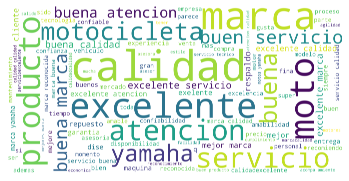

In [34]:
nps.Comentario = nps.Comentario.astype(str).apply(lambda x: x.lower())
promotor=nps[nps["NPS_CUALI"]=='Promotor']
word_cloud_text = ''.join(promotor.Comentario)
print(len(word_cloud_text))

wordcloud = WordCloud(
    max_font_size=100,
    max_words=100,
    background_color="white",
    scale=10,
    width=800,
    height=400,
    stopwords=stop_words
).generate(word_cloud_text)

plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

#### El wordcloud brinda algunas pistas sobre las descripciones brindadas para los promoteres
buen servicio
excelente servicio
amabilidad
atencion 
buena marca

400498


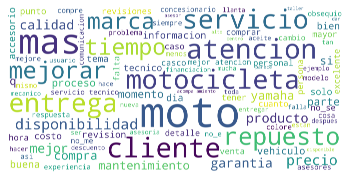

In [35]:
nps.Comentario = nps.Comentario.astype(str).apply(lambda x: x.lower())
pasivo=nps[nps["NPS_CUALI"]=='Pasivo']
word_cloud_text = ''.join(pasivo.Comentario)
print(len(word_cloud_text))

wordcloud = WordCloud(
    max_font_size=100,
    max_words=100,
    background_color="white",
    scale=10,
    width=800,
    height=400,
    stopwords=stop_words
).generate(word_cloud_text)

plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

280863


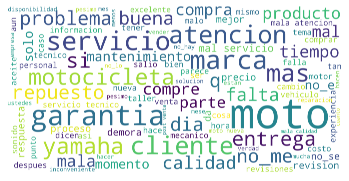

In [36]:
nps.Comentario = nps.Comentario.astype(str).apply(lambda x: x.lower())
Detractor=nps[nps["NPS_CUALI"]=='Detractor']
word_cloud_text = ''.join(Detractor.Comentario)
print(len(word_cloud_text))

wordcloud = WordCloud(
    max_font_size=100,
    max_words=100,
    background_color="white",
    scale=10,
    width=800,
    height=400,
    stopwords=stop_words
).generate(word_cloud_text)

plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [37]:
### N gramas
from collections import Counter
n = 5
fivegrams = ngrams(''.join(str(v) for v in Detractor.Comentario.str.replace('[^\w\s]',"")).split(), n)


resultado = Counter(fivegrams)
for grams in fivegrams:
    print(grams)
import itertools
bigrams = list(itertools.chain(*fivegrams))

In [38]:
k = Counter(resultado)
 
# Finding 3 highest values
high = k.most_common(5)
 
print("Initial Dictionary:")
print(resultado, "\n")
 
 
print("Dictionary with 3 highest values:")
print("Keys: Values")
 
for i in high:
    print(i[0]," :",i[1]," ")

Initial Dictionary:
Counter({('la', 'entrega', 'de', 'la', 'moto'): 14, ('en', 'la', 'entrega', 'de', 'la'): 13, ('la', 'entrega', 'de', 'la', 'motocicleta'): 7, ('el', 'tiempo', 'de', 'entrega', 'de'): 6, ('de', 'la', 'entrega', 'de', 'la'): 6, ('demora', 'en', 'la', 'entrega', 'de'): 6, ('de', 'entrega', 'de', 'la', 'motocicleta'): 5, ('demora', 'en', 'la', 'entrega', 'del'): 5, ('la', 'marca', 'es', 'muy', 'buena'): 5, ('a', 'la', 'hora', 'de', 'adquirir'): 5, ('a', 'la', 'hora', 'de', 'la'): 5, ('en', 'el', 'momento', 'de', 'la'): 5, ('mucha', 'demora', 'en', 'la', 'entrega'): 5, ('y', 'lo', 'peor', 'es', 'que'): 4, ('tiempo', 'de', 'entrega', 'de', 'la'): 4, ('la', 'compra', 'de', 'la', 'moto'): 4, ('entrega', 'de', 'la', 'moto', 'y'): 4, ('por', 'parte', 'de', 'los', 'asesores'): 4, ('como', 'es', 'posible', 'que', 'una'): 4, ('de', 'la', 'moto', 'y', 'me'): 4, ('de', 'la', 'moto', 'que', 'compre'): 4, ('pero', 'el', 'servicio', 'al', 'cliente'): 4, ('posible', 'que', 'una', 'mot

In [39]:
from sklearn.feature_extraction.text import CountVectorizer
vec=CountVectorizer(stop_words=stop_words)
X = vec.fit_transform(Detractor.Comentario)
vectorizer2 = CountVectorizer(analyzer='word', ngram_range=(5, 5), stop_words=stop_words)
X2 = vectorizer2.fit_transform(Detractor.Comentario)

In [40]:
print(nps['ModeloMoto'].isna().sum())
print(vectorizer2.vocabulary_)

0
{'parece productos caros no_ofrecen sistema': 10962, 'productos caros no_ofrecen sistema abs': 12212, 'caros no_ofrecen sistema abs minimo': 1949, 'no_ofrecen sistema abs minimo debe': 10164, 'sistema abs minimo debe tener': 14218, 'abs minimo debe tener moto': 264, 'prematuro calificar 10 moto hace': 11758, 'calificar 10 moto hace tiempo': 1804, 'falta respeto cliente no_dar solucion': 5298, 'respeto cliente no_dar solucion inconvenientes': 12997, 'cliente no_dar solucion inconvenientes presentaron': 2206, 'no_dar solucion inconvenientes presentaron no_entregar': 9659, 'solucion inconvenientes presentaron no_entregar informacion': 14359, 'inconvenientes presentaron no_entregar informacion adecuada': 6450, 'presentaron no_entregar informacion adecuada peor': 11829, 'no_entregar informacion adecuada peor trataron': 9701, 'informacion adecuada peor trataron hacerme': 6497, 'adecuada peor trataron hacerme ver': 418, 'peor trataron hacerme ver si': 11185, 'trataron hacerme ver si culpa':

In [41]:
## tener presente
print(nps['Tasa_Retorno'].value_counts(dropna=False))
print(nps['Valor_NPS'].value_counts(dropna=False))

NaN    19145
1      18038
0       2979
Name: Tasa_Retorno, dtype: int64
10    24455
9      6669
8      4291
7      1786
5       819
6       666
0       530
4       288
3       285
2       198
1       175
Name: Valor_NPS, dtype: int64


In [42]:
nps['Sentiment_rating'] = np.where(nps.Valor_NPS > 8, 1, 0)
nps['Sentiment_rating'].value_counts()

1    31124
0     9038
Name: Sentiment_rating, dtype: int64

In [45]:
100 * nps.Valor_NPS.value_counts(True)

10    60.890892
9     16.605249
8     10.684229
7      4.446990
5      2.039241
6      1.658284
0      1.319655
4      0.717096
3      0.709626
2      0.493003
1      0.435735
Name: Valor_NPS, dtype: float64

In [46]:

token_lists = [word_tokenize(each) for each in nps.Comentario]
tokens = [item for sublist in token_lists for item in sublist]
print("Number of unique tokens then: ", len(set(tokens)))


Number of unique tokens then:  11999


### NGRAMAS que permiten identificar tópicos importantes a tráves de todos los comentarios

In [49]:
one_percentile = int(len(set(tokens)) * 0.01)
top_1_percentile = Counter(tokens).most_common(one_percentile)
print(top_1_percentile[:10],'Top 10')

tail_1_percentile = Counter(tokens).most_common()[-one_percentile:]
print(tail_1_percentile[:10],'Tail 10')


[('la', 16025), ('y', 14771), ('de', 14549), ('calidad', 10176), ('marca', 8457), ('excelente', 7958), ('servicio', 7465), ('muy', 7078), ('en', 7062), ('que', 7003)] Top 10
[('ban', 1), ('pprque', 1), ('aiga', 1), ('xc', 1), ('especificando', 1), ('adquirlo', 1), ('asesriia', 1), ('interactuen', 1), ('benefico', 1), ('prestador', 1)] Tail 10


In [51]:
from nltk.stem import PorterStemmer

stemmer = PorterStemmer()
analyzer = CountVectorizer().build_analyzer()
def stemmed_words(doc):
    return (stemmer.stem(w) for w in analyzer(doc))

In [52]:
# CObjeto que cuente los vectores 

bow_counts = CountVectorizer(
    tokenizer=word_tokenize,
    stop_words=stop_words,
    ngram_range=(1, 1)
)
from sklearn.model_selection import train_test_split ##3 DIvision del dataset
reviews_train, reviews_test = train_test_split(nps, test_size=0.2, random_state=0)
X_train_bow = bow_counts.fit_transform(reviews_train.Comentario)
X_test_bow = bow_counts.transform(reviews_test.Comentario)

C:\Users\Usser\anaconda3\envs\myenv\lib\site-packages\sklearn\feature_extraction\text.py:391: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ["'d", "'ll", "'re", "'s", "'ve", 'could', 'might', 'must', "n't", 'need', 'sha', 'wo', 'would'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


In [53]:
y_train_bow = reviews_train['Sentiment_rating']
y_test_bow = reviews_test['Sentiment_rating']

In [54]:
y_test_bow.value_counts(True) 

1    0.777169
0    0.222831
Name: Sentiment_rating, dtype: float64

In [55]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer

In [57]:
# Training the model 
lr_model_all = LogisticRegression(C=1, solver="liblinear")
lr_model_all.fit(X_train_bow, y_train_bow)

# Predicting the output
test_pred_lr_prob = lr_model_all.predict_proba(X_test_bow)
test_pred_lr_all = lr_model_all.predict(X_test_bow)

print("F1 score: ", f1_score(y_test_bow, test_pred_lr_all))
print("Accuracy: ", accuracy_score(y_test_bow, test_pred_lr_all) * 100)

F1 score:  0.9454829878764176
Accuracy:  91.32329142288062


In [58]:
probabilities = [each[1] for each in test_pred_lr_prob]

In [59]:
predictions = pd.DataFrame()
predictions['Comentario'] = reviews_test['Comentario']
predictions['Actual_Score'] = reviews_test['Valor_NPS']
predictions['Sentiment_rating'] = reviews_test['Sentiment_rating']
predictions['Predicted_sentiment'] = test_pred_lr_all
predictions['Predicted_probability'] = probabilities

In [60]:
predictions.head(5)

,Comentario,Actual_Score,Sentiment_rating,Predicted_sentiment,Predicted_probability
3383,son una empresa muy seria muy buena en respect...,9,1,1,0.986465
13229,asesoria puntualidad excelente atencion,10,1,1,0.987335
25408,la accesorias del servicio,10,1,1,0.501787
10977,excelente calidad,10,1,1,0.998867
1575,excelente calidad de la motocicleta,10,1,1,0.998836


In [61]:
accuracy_score(predictions['Sentiment_rating'], predictions['Predicted_sentiment'])

0.9132329142288061

In [62]:
predictions[
    predictions['Predicted_sentiment'] != predictions['Sentiment_rating']
].sort_values(by=["Predicted_probability"]).head(3)

,Comentario,Actual_Score,Sentiment_rating,Predicted_sentiment,Predicted_probability
13130,la moto q queria la encontre aunque en la prin...,10,1,0,0.000007
16216,mas q recomendarlos mas bien les sugiero que ...,10,1,0,0.000359
12258,cuando realicen el tramite del credito lo haga...,10,1,0,0.000388


In [63]:
predictions[predictions['Predicted_sentiment']==1]

,Comentario,Actual_Score,Sentiment_rating,Predicted_sentiment,Predicted_probability
3383,son una empresa muy seria muy buena en respect...,9,1,1,0.986465
13229,asesoria puntualidad excelente atencion,10,1,1,0.987335
25408,la accesorias del servicio,10,1,1,0.501787
10977,excelente calidad,10,1,1,0.998867
1575,excelente calidad de la motocicleta,10,1,1,0.998836
...,...,...,...,...,...
32692,la calidad del producto y la excelente atencion,10,1,1,0.999533
9247,porque ya he tenido una ybr y me salio muy buena,10,1,1,0.919347
28514,calidad respaldo,10,1,1,0.996599
33485,la calidad,9,1,1,0.960780


## TOP de comentarios de personas que tiene una muy buena percepción 

In [64]:
lr_weights = pd.DataFrame(list(
    zip(
        bow_counts.get_feature_names(),
        lr_model_all.coef_[0])
    ),
    columns=['words','weights']
)

lr_weights.sort_values(['weights'],ascending = False)[:15]

,words,weights
3954,excelente,3.583200
3956,excelentes,3.260102
3997,exelente,3.152340
1357,buen,3.067243
1502,calidad,2.846516
3950,excelencia,2.710761
1360,buenas,2.528531
8650,respaldo,2.481818
3999,exelentes,2.441674
2201,confiabilidad,2.424929


## Top de 15 quejas más frecuentes que perjudican el NPS

In [65]:
lr_weights.sort_values(['weights'],ascending = False)[-15:]

,words,weights
2809,demora,-2.122183
1167,bajado,-2.127121
2463,costos,-2.134811
5831,mas,-2.147846
7759,precios,-2.270863
6555,no_es,-2.300718
5858,mayor,-2.361458
5532,llantas,-2.395326
4159,fallas,-2.470134
4169,falta,-2.486566


In [66]:
# predictions[predictions['Predicted_sentiment']==0]

In [68]:
# predictions[predictions['Predicted_sentiment']==0]
# predictions[predictions['Predicted_sentiment']==0]
predictions.loc[29026].values

array(['por mal servicio  por la desconfianza que genera las reviciones tecnicas por parte del personal del area del taller  son muy jovenes y mal preparados para atender de manera eficiente motocicletas de la tecnologia que comercializa yamaha  ',
       1, 0, 0, 0.01825627975441576], dtype=object)

### Que nos permitió el análisis anterior:
* Encontrar palabras recurrentes que faciliten la identificación del sentimiento luego de ello se debe relacionar con lo score del NPS

A través de los años se ha detectado que los clientes compran motocicletas de la marca en repetidas ocasiones e incluso van evolucionando sus hábitos de compra, para monitorear estos eventos, adjunto encuentras el dataset “compras.csv” en el cual se detalla:

•	Cliente_key: ID para identificar el cliente
•	Fecha_Venta: la fecha en que compra la motocicleta
•	Fecha_Anterior: fecha inmediatamente anterior a la última compra
•	Intervalo_Recompra_dias_Ant: días transcurridos desde la fecha de compra anterior a la compra actual
•	Distribuidor_Anterior: tienda donde compró la motocicleta en la fecha anterior
•	Distribuidor_Actual: tienda donde compró la motocicleta en la ocasión más reciente
•	NombreComercial_Anterior: motocicleta adquirida en la ocasión anterior
•	NombreComercial_Actual: motocicleta que esta adquiriendo en la fecha
•	NombreCategoria_Anterior: categoría de la moto adquirida en la ocasión anterior
•	NombreCategoria_Actual: categoría de la moto adquirida en la fecha
•	Id_Municipio: municipio donde vive la persona que compra la moto	
•	Id_Departamento: departamento donde vive la persona que compra la moto

Ejemplo: para aclarar la información en el dataset tomemos el caso del cliente 3831:
Ha comprado en total 5 motocicletas, la primera de ellas en julio de 2007, luego en noviembre de 2010, luego en noviembre de 2015, luego en enero de 2016 y finalmente en marzo de 2018, nunca ha comprado dos motocicletas del mismo modelo, pero sí de la misma categoría, no ha cambiado su lugar de residencia y ha visitado 3 distribuidores distintos a lo largo del tiempo, siendo el CL119081 el único en el que no ha repetido.


In [69]:
########################## tartamiento a la Bd de compras #######################
compras=pd.read_csv(r"D:\Desktop\ITS_\YAMAHA\compras.csv",sep=';',encoding='latin-1',dtype=str)
##################################################### Cleaning ########################
compras['week_day']=compras['Fecha_Venta'].str.replace('(.*)\,.*', '\\1')
compras['Fecha_Venta']=compras['Fecha_Venta'].str.replace('.*,\s(.*)\.*', '\\1').str.replace('de', '-').str.replace('  ', ' ')
compras['Fecha_Venta']=compras['Fecha_Venta'].str.replace(' ','')
compras['Fecha_Venta'].str.replace('.*-(.*)-.*', '\\1').unique() # identifico los meses
dic= {'junio':'06', 'febrero':'02', 'agosto':'08', 'julio':'07', 'enero':'01', 'noviembre':'11',
       'abril':'04', 'mayo':'05', 'octubre':'10', 'diciembre':'12', 'marzo':'03', 'septiembre':'09'}
compras['Fecha_Venta']=compras['Fecha_Venta'].astype(str).replace(dic,regex=True)
compras['Fecha_Venta']=pd.to_datetime(compras['Fecha_Venta'],format='%d-%m-%Y',errors='coerce')
compras['Fecha_Anterior']=compras['Fecha_Anterior'].str.replace('.*,\s(.*)\.*', '\\1').str.replace('de', '-').str.replace('  ', ' ')
compras['Fecha_Anterior']=compras['Fecha_Anterior'].str.replace(' ','')
compras['Fecha_Anterior']=compras['Fecha_Anterior'].astype(str).replace(dic,regex=True)
compras['Fecha_Anterior']=pd.to_datetime(compras['Fecha_Anterior'],format='%d-%m-%Y',errors='coerce')

In [70]:
compras.sort_values(['Cliente_Key','Fecha_Venta'],ascending=True,inplace=True)

In [71]:
compras['Fecha_Siguiente']=pd.to_datetime(compras['Fecha_Siguiente'],infer_datetime_format=True,errors='coerce')

In [72]:
compras['sequence']=(compras.sort_values(by=['Cliente_Key','Fecha_Venta'], ascending=True).
                            groupby(['Cliente_Key'])).cumcount()+1

In [73]:
compras['recompra']=np.where(compras['sequence']>1,'si','no')

In [74]:
compras['Intervalo_Recompra_dias_Ant']=compras['Intervalo_Recompra_dias_Ant'].astype(float)

### Concentración de la recompra

<AxesSubplot:>

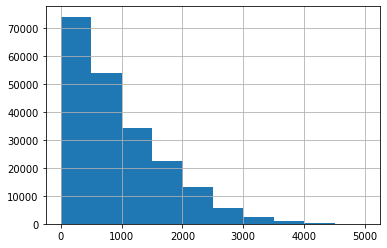

In [75]:
compras[compras['recompra']=='si']['Intervalo_Recompra_dias_Ant'].hist()

## Muy importante comparar las dos distribuciones

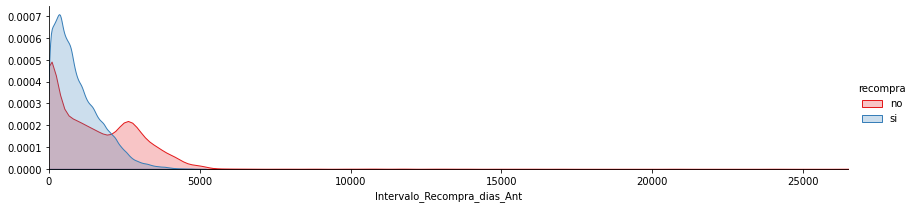

In [76]:
a = sns.FacetGrid(compras, hue = 'recompra', aspect=4, palette="Set1" )
a.map(sns.kdeplot, 'Intervalo_Recompra_dias_Ant', shade= True )
a.set(xlim=(0 , compras['Intervalo_Recompra_dias_Ant'].max()))
a.add_legend()

* Se plantea buscar las variables importantes a través de un modelo de boosting (algoritmo de votación que nos va a permitir identificar carateristicas importantes)
* Se crea la variabel secuencia para identificar la cantidad de vehiculos que se adquirieron, dado el caso en el que no se tiene la primera venta se debe adicionar un condicional si tiene fecha anterior en su primera compra en el dataset sumele 1. (como en el caso de ejemplo)
* Se puede realizar un modelo Hazard para identificar la supervivencia (el momento en el que recae un individuo)
* Si se tiene el precio de la moto, muy interesante  notar el diferencial en precio como variable dependiente


In [77]:
compras.drop(['Cliente_Key','Fecha_Venta','Fecha_Anterior','week_day'],axis=1,inplace=True)
compras['recompra'].value_counts(True)

no    0.784079
si    0.215921
Name: recompra, dtype: float64

In [78]:
compras[compras['Cliente_Key'].duplicated()] ## Identificar los duplicados

KeyError: 'Cliente_Key'